In [ ]:
**Задачи** до *28 октября* включительно  
**_задача 2_**  
А) Используем данные с прошлого д/з  
Б) Пробуем tsfresh, tsfel  
В) Применяем k-means ( нужно передать feature matrix на вход k-means)  
Г) Визуализируем результат  
Д) Пишем сравнительный анализ с фич экстрактором и без него (5 - 10 предложений)  
**_задача 3_**  
А) Используем данные с прошлого д/з  
Б) Применяем DTW, визуализируем  
В) Применяем иерархический DTW, визуализируем  
Г) Пишем сравнительные анализ иерархического и нормального DTW. Чем отличаются методы?  
Д) Что такое DTW distance? Как оно рассчитывается?  

Я использовал для выполнения прошлого д/з две группы данных  
Использую более разнообразную

In [27]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns

from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from dtaidistance import dtw
import scipy.cluster.hierarchy as shc
from tqdm import tqdm

from tsfresh import extract_features
from tsfresh import extract_relevant_features
import tsfel

In [28]:
# как использовать tsfel

# cfg_file = tsfel.get_features_by_domain()               # All features will be extracted.
# cgf_file = tsfel.get_features_by_domain("statistical")  # All statistical domain features will be extracted
# cgf_file = tsfel.get_features_by_domain("temporal")     # All temporal domain features will be extracted
# cgf_file = tsfel.get_features_by_domain("spectral")     # All spectral domain features will be extracted

In [29]:
# Учитываю комментарий к прошлому д/з и делаю графики побольше
%matplotlib inline
rcParams['figure.figsize'] = 16, 10

## ------------------------------------------------------------------------------ ##  
# Данные из задания 1  
## ------------------------------------------------------------------------------ ##

In [30]:
new_companies = ' UNH JNJ LLY ABBV PFE NVO MRK TMO DHR ABT NVS AZN BMY CVS '
new_companies += ' AMZN TSLA HD BABA TM MCD NKE SBUX PDD MA V '
new_companies += ' WMT PG KO PEP COST FMX PM UL DEO BUD EL SQM IFF '
new_companies += ' XOM CVX SHEL COP TTE EQNR BP PBR ENB EOG OXY CNQ SLB MPC '

new_data = yf.download(new_companies, '2018-01-01', '2022-01-01', group_by = 'column' )


[*********************100%***********************]  52 of 52 completed


In [31]:
new_prices = new_data['Adj Close'].dropna()
print(new_prices.shape)

(866, 52)


In [83]:
new_companies = ['UNH', 'JNJ', 'LLY', 'ABBV', 'PFE', 'NVO', 'MRK', 'TMO', 'DHR', 'ABT', 'NVS', 'AZN', 'BMY', 'CVS',
                 'AMZN', 'TSLA', 'HD', 'BABA', 'TM', 'MCD', 'NKE', 'SBUX', 'PDD', 'MA', 'V',
                 'WMT', 'PG', 'KO', 'PEP', 'COST', 'FMX', 'PM', 'UL', 'DEO', 'BUD', 'EL', 'SQM', 'IFF',
                 'XOM', 'CVX', 'SHEL', 'COP', 'TTE', 'EQNR', 'BP', 'PBR', 'ENB', 'EOG', 'OXY', 'CNQ', 'SLB', 'MPC']
new_prices.loc[:, new_companies]


,UNH,JNJ,LLY,ABBV,PFE,NVO,MRK,TMO,DHR,ABT,...,TTE,EQNR,BP,PBR,ENB,EOG,OXY,CNQ,SLB,MPC
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-26,241.245255,116.475830,87.990295,76.561218,31.022995,47.477318,53.491829,231.642731,101.945000,61.332794,...,48.323589,21.813288,34.730240,6.373027,27.801466,109.545380,74.100166,28.010654,58.319103,67.867928
2018-07-27,240.259583,117.611275,89.303032,73.806519,31.226252,47.282738,53.057274,228.771942,100.923492,60.959152,...,49.012497,21.931244,34.714642,6.548988,27.635363,109.791924,73.492638,27.862772,58.476105,68.570641
2018-07-30,238.278961,118.165558,90.615746,74.531845,31.372589,46.986237,54.160378,228.395737,100.000191,60.875076,...,49.188564,22.074480,34.636650,6.521494,27.928013,110.429504,73.351746,28.384230,58.947128,69.002457
2018-07-31,237.696976,118.478493,91.346085,75.167572,32.461975,46.115261,55.046196,232.167374,100.756538,61.220707,...,49.946365,22.293533,35.166996,6.450010,28.022924,109.613411,73.897644,28.516539,58.894787,68.435188
2018-08-01,237.837753,118.585762,91.244377,76.536774,32.738384,45.985542,54.728638,231.553635,100.186836,60.510792,...,49.425846,22.209286,34.730240,6.444511,27.888466,106.748528,72.761841,28.275263,58.144653,68.375923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,494.704254,166.393387,275.422302,129.369675,57.829311,109.975258,74.676788,661.097046,326.272430,139.125427,...,48.246758,26.663872,26.263720,7.711892,36.696800,85.374969,29.454355,39.136520,29.503151,62.845203
2021-12-28,498.111206,167.060257,273.463562,129.350418,56.666862,109.137856,74.910858,654.278442,322.316254,138.151764,...,48.445385,26.430660,26.195982,7.725813,36.563145,84.848312,29.295359,39.034191,29.770102,63.129616
2021-12-29,500.725861,168.237076,275.432220,130.284073,56.246819,109.512230,75.047386,661.616089,325.656769,138.859879,...,48.208927,26.207163,26.118565,7.586608,36.649067,84.500351,29.076738,38.978371,29.315296,62.717709


In [ ]:
scaler = StandardScaler()
new_prices_scaled = scaler.fit_transform(new_prices.iloc[:].T).T

In [34]:
distortions = []
silhouette = []
K = range(2,10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters = k, metric = 'euclidean', n_jobs = 6, max_iter = 10, n_init=5)
    kmeanModel.fit(new_prices_scaled)
    distortions.append(kmeanModel.inertia_)
    silhouette.append(silhouette_score(new_prices_scaled, kmeanModel.labels_, metric = "euclidean"))

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.66s/it]


In [35]:
n_clusters = 5
ts_kmeans = TimeSeriesKMeans( n_clusters=n_clusters, metric="euclidean", n_jobs=6, max_iter=10)
ts_kmeans.fit(new_prices_scaled)

TimeSeriesKMeans(max_iter=10, n_clusters=5, n_jobs=6)

## ----------------------------------------------------------------------------------------------- ##  
# Задание 2
## ----------------------------------------------------------------------------------------------- ##  

In [36]:
# пример как всё работает из документации
# ты посмотрел как здесь устроены id и time
# видно, что время и айди -- отдельные столбцы
from tsfresh import extract_features
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, \
    load_robot_execution_failures
download_robot_execution_failures()
df, _ = load_robot_execution_failures()
print(df)
# X = extract_features(df, column_id='id', column_sort='time')

      id  time  F_x  F_y  F_z  T_x  T_y  T_z
0      1     0   -1   -1   63   -3   -1    0
1      1     1    0    0   62   -3   -1    0
2      1     2   -1   -1   61   -3    0    0
3      1     3   -1   -1   63   -2   -1    0
4      1     4   -1   -1   63   -3   -1    0
...   ..   ...  ...  ...  ...  ...  ...  ...
1315  88    10  -10    2   39  -21  -24    5
1316  88    11  -11    2   38  -24  -22    6
1317  88    12  -12    3   23  -24  -24    5
1318  88    13  -13    4   26  -29  -27    5
1319  88    14  -13    2   15  -25  -25    6

[1320 rows x 8 columns]


In [37]:
# создаю строку, по которой будет происходить экстракция
new_prices_scaled_pd = pd.DataFrame(new_prices_scaled)
# ii = []
# for i in range(52):
#     ii.append(i)
# iii = []
# for i in range(866):
#     iii.append(i)

# ii = pd.DataFrame(ii, columns = list('i'))
# iii = pd.DataFrame(iii)
# new_prices_scaled_pd = new_prices_scaled_pd.append(ii.T)
print(new_prices_scaled_pd)

           0         1         2         3         4         5         6   \
0   -0.178951 -0.451770  0.068972 -0.946314  1.928203 -0.641566 -0.928358   
1   -0.223518 -0.456326  0.085573 -0.948502  1.871522 -0.657407 -0.931904   
2   -0.207486 -0.457772  0.056955 -0.949784  1.813750 -0.627327 -0.938640   
3   -0.199849 -0.454855  0.050725 -0.941696  1.849119 -0.633218 -0.931226   
4   -0.168599 -0.461531  0.074903 -0.941387  1.818890 -0.612932 -0.932763   
..        ...       ...       ...       ...       ...       ...       ...   
861 -0.165082 -0.096974  0.116261 -0.672303 -0.254300 -0.646480 -0.884889   
862 -0.164552 -0.102955  0.124564 -0.671121 -0.266384 -0.646604 -0.886487   
863 -0.160520 -0.100998  0.109589 -0.667140 -0.286799 -0.645467 -0.883498   
864 -0.156804 -0.102215  0.106468 -0.670076 -0.211411 -0.645557 -0.887918   
865 -0.160610 -0.104371  0.092243 -0.670715 -0.240733 -0.645902 -0.886994   

           7         8         9   ...        42        43        44  \
0  

In [38]:
# Алгоритм действия:
# Сливаю все столбцы датафрейма в один:
# создаю лист длиной 52 * 866,
# значения в этом листе имеют период повторений 866
# Также добавлю строку id. 866 первых значений столбца айди
# есть 0, затем следующие 866 значений столбца есть 1
# и так далее до 866

# создаю лист с стремя столбцами, каждый столбец размера 45032
column = [[0] * 45032] * 3
j = 0
# в первый столбец засовываю значения активов
for i in range(52):
    for k in range(866):
        column[0][j] = new_prices_scaled_pd[i][k]
        j+=1

In [39]:
# теперь засовываю в второй и третий столбцы 
# значения времени и айди

# создание столбца времени и столбца айди
column_time = [0] * 45032 
column_id = [0] * 45032
j = 0
k = 0
for i in range(45032):
    column_time[i] = j
    j+=1
    column_id[i] = k
    if j == 866:
        j = 0
        k+=1

# второй столбец есть время
column[1] = column_time
# третий столбец есть айди
column[2] = column_id

# теперь лист преобразовываю в датафрейм
column_pd = pd.DataFrame(column)
# транспонирую дата фрейм, чтобы всё было по столбцам
column_pd = column_pd.T
# переименовываю индексы столбцов, чтобы легче было их вызвать
# при экстрации
column_pd.rename(columns={0:'Value'}, inplace=True)
column_pd.rename(columns={1:'time'}, inplace=True)
column_pd.rename(columns={2:'index'}, inplace=True)
# смотрю результат
column_pd.head(10)

,Value,time,index
0,-0.178951,0.0,0.0
1,-0.223518,1.0,0.0
2,-0.207486,2.0,0.0
3,-0.199849,3.0,0.0
4,-0.168599,4.0,0.0
5,-0.151657,5.0,0.0
6,-0.133912,6.0,0.0
7,-0.127398,7.0,0.0
8,-0.176912,8.0,0.0
9,-0.178791,9.0,0.0


Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 18/18 [00:31<00:00,  1.75s/it]

*** Feature extraction started ***



*** Feature extraction finished ***


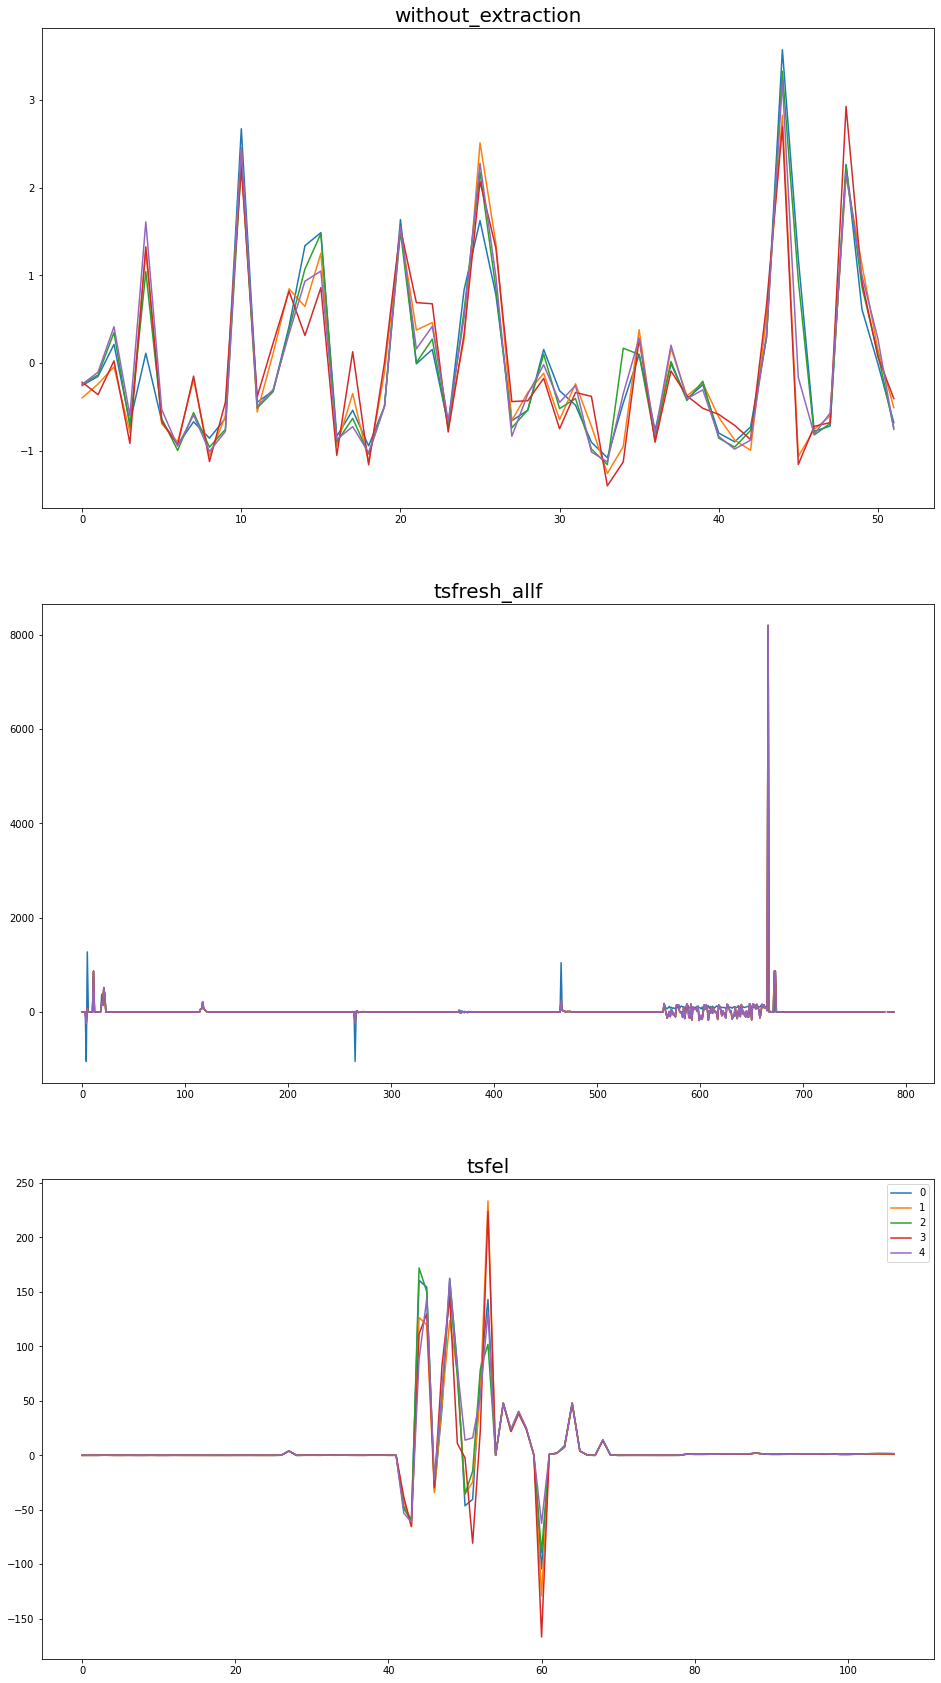

In [40]:
# для данного блока меняю размер графиков
rcParams['figure.figsize'] = 16, 30

# занимаюсь экстракцией фичей
# библиотека tsfresh
new_prices_scaled_tsfresh_allf = extract_features(column_pd, column_id = 'index', column_sort = 'time')

# библиотека tsfel
cfg_file = tsfel.get_features_by_domain('spectral')
X_train = tsfel.time_series_features_extractor(cfg_file, new_prices_scaled, fs= 100 )

# рисую графики и смотрю что получается

# без экстракции
ts_kmeans.fit(new_prices_scaled)
plt.subplot(3,1,1)
for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans.cluster_centers_[cluster_number, :, 0].T, label = cluster_number)
plt.title('without_extraction', fontsize = 20)

# tsfresh
ts_kmeans.fit(new_prices_scaled_tsfresh_allf)
plt.subplot(3,1,2)
for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans.cluster_centers_[cluster_number, :, 0].T, label = cluster_number)
plt.title('tsfresh_allf', fontsize = 20)

# tsfel
ts_kmeans.fit(X_train)
plt.subplot(3,1,3)
for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans.cluster_centers_[cluster_number, :, 0].T, label = cluster_number)
plt.title('tsfel', fontsize = 20)

plt.legend()
plt.show()

In [41]:
# возвращаю размер графиков к исходному значению
rcParams['figure.figsize'] = 16, 10

_Наблюдение:  
Я уже n-ый час сижу за данным блоком кода, у меня долгое время не получалось экстрагировать данные  
И дюжину времени потратил на написание корректного кода для tsfel.  
TSFRESH всё это время разбивает от 2 до 5 кластеров (остальные сливаются), но чаще на два._  
  
После применения экстрагентов модель, к примеру для случая tsfresh, разбивает, как правило, на меньшее  
количество кластеров. Глядя на график можно сказать, что кластеры различаются между собой существенно.  
Для tsfel модель разбивает активы на кластеры, которые, судя по графику, различаются между собой в какой-то  
конкретный интервал времени существенно, но в остальном почти схожи.  
Стоит отметить, что tsfresh и tsfel едят разные форматы данных, это может влиять на кластеризацию модели.  
Возможно, я разобрался не достаточно хорошо в одном из экстрагентов, что сильно влияет на кластеризацию.  
  
Побалуюсь ещё с экстрагентами, с их параметрами. Самое интересное на мой взгляд вставлю в следующий  
или следующие блоки кода


In [42]:
# Изменение различных параметров tsfel и tsfresh не привело к сильным  
# изменением результатов

# вопрос!
# вопрос!
# new_prices_scaled_tsfresh_relevantf = extract_relevant_features(column_pd, y ,column_id = 'index', column_sort = 'time')
# что в extract_relevant_features значит 'y'? Я не совсем понял

Сравнительный анализ:  
Экстракторы требуют различный формат данных на вход. Это может создать некоторые трудности при написании кода. Экстракторы могут уменьшить количество кластеров, выдаваемые моделью. При должном оперировании с экстракторами, можно получить кластеризацию, которая будет различасть кластеры существенно. Это продемонстировала экстракция tsfresh'ом. 

## ------------------------------------------------------------------------------------ ##  
# Задание 3  
## ------------------------------------------------------------------------------------ ##

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [37:14<00:00, 279.31s/it]


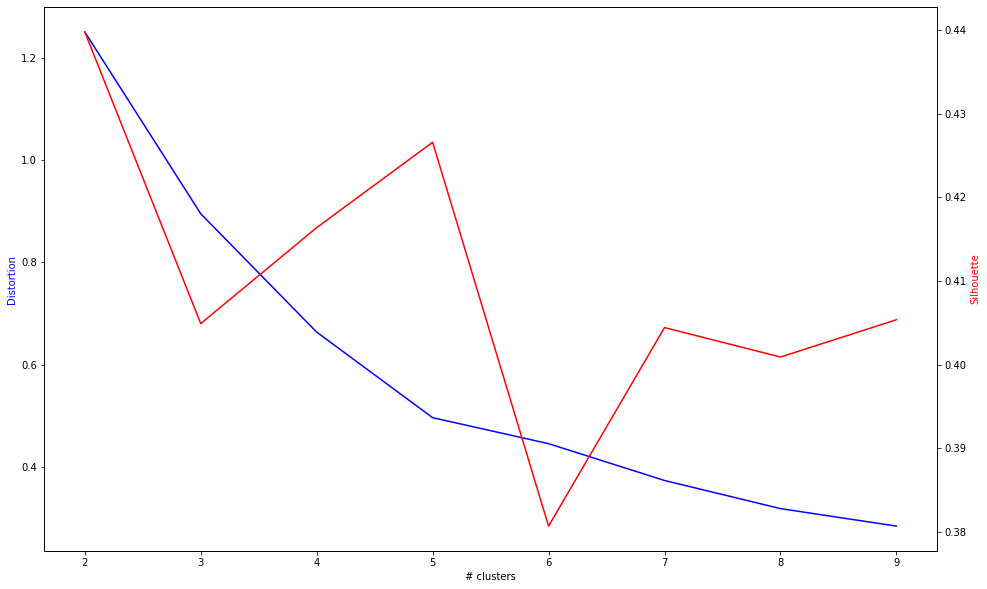

In [44]:
distortions = []
silhouette = []
K = range(2, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="dtw", n_jobs=6, max_iter=10, n_init=5)
    kmeanModel.fit(new_prices_scaled)
    distortions.append(kmeanModel.inertia_)
    silhouette.append(silhouette_score(new_prices_scaled, kmeanModel.labels_, metric="dtw"))

    
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(K, distortions, 'b-')
ax2.plot(K, silhouette, 'r-')

ax1.set_xlabel('# clusters',  fontsize = 20)
ax1.set_ylabel('Distortion', color='b',  fontsize = 20)
ax2.set_ylabel('Silhouette', color='r',  fontsize = 20)

plt.show()

На плечо совсем не похоже  
Возьму 5. Синенькое хоть чуть-чуть на плечо похоже.

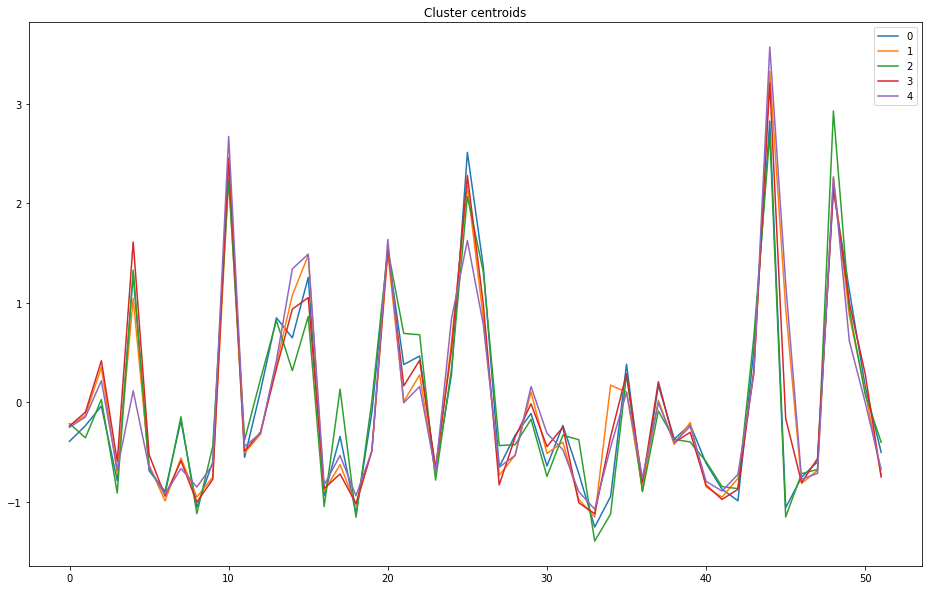

In [45]:
# чтобы не портить себе жизнь воспользуюсь данными без экстракции
n_clusters = 5
ts_kmeans_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", n_jobs=6, max_iter=10)
ts_kmeans_dtw.fit(new_prices_scaled)

for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans_dtw.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids",  fontsize = 20)
plt.legend()
plt.show()

Наблюдение: Кластеры теперь, на мой взгляд, отличаются сильнее

In [80]:
# иерархический dtw

# Custom Hierarchical clustering
model1 = clustering.Hierarchical(dtw.distance_matrix_fast, {})
cluster_idx = model1.fit(new_prices_scaled)
# Keep track of full tree by using the HierarchicalTree wrapper class
model2 = clustering.HierarchicalTree(model1)
cluster_idx = model2.fit(new_prices_scaled)
# You can also pass keyword arguments identical to instantiate a Hierarchical object
model2 = clustering.HierarchicalTree(dists_fun=dtw.distance_matrix_fast, dists_options={})
cluster_idx = model2.fit(new_prices_scaled)
# SciPy linkage clustering
dtw_cluster = clustering.LinkageTree(dtw.distance_matrix_fast, {})
cluster_idx = dtw_cluster.fit(new_prices_scaled)

100%|██████████████████████████████████████████████████████████████████████████████▉| 865/866 [00:04<00:00, 188.12it/s]


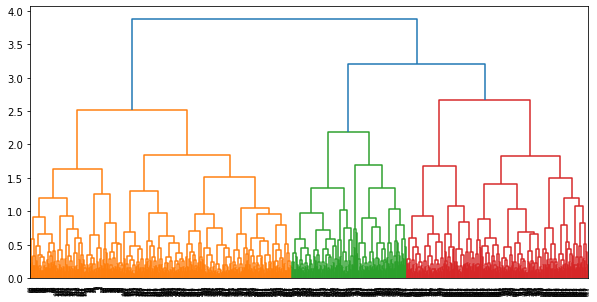

In [81]:
# строю график
shc.dendrogram(cluster_idx)
plt.show()

Иерархическая кластеризация с DTW и Kmeans с DTW отличаются методами. KMeans -- смотрит на плотность. К примеру, "возрастающий" иерархический метод сначала разбивается по конкретным точкам временного ряда, затем похожие точки срастаются и образуют кластер. От обычного "возрастающего" иерархического метода отличается исключительно метрикой. Я использовал "понижающуюся" иерархическую кластеризацию. В одном кластере сначала содержатся все элементы, затем элементы разбиваются на отдельные кластеры по похожести.

Что такое DTW distance?  
украл из леции:  
$$DTW(x, y) = min_{\pi} \sqrt{\sum_{(i,j)\in \pi} d(x_i, y_j)^2},$$

где $\pi = [\pi_0, ..., \pi_K]$ - это путь, удовлетворяющий набору условий:
- это лист парных индексов $\pi_k = (i_k, j_k)$, где  $0\leq i_k < n$ и $0\leq j_k < m$
- $\pi_0 = (0, 0)$ и $\pi_K = (n-1, m-1)$
- для всех $k>0$, $\pi_k=(i_k, j_k)$ и $\pi_{k-1}=(i_{k-1}, j_{k-1})$ удовлетворяют следующим неравенствам:
    - $i_{k-1} \leq i_k \leq i_{k-1} + 1$
    - $j_{j-1} \leq j_k \leq j_{k-1} + 1$  
      
Своими словами:  
Имеется два временных ряда. У этих двух временных рядов берутся похожие по тангенсу значения на промежутках временных рядов. Если у какого-то временного ряда сильно изменяется тангенс(производная), а у второго нет, то из предыдущей точки для первого ряда находятся дистации до точек со второго ряда до тех пор, пока у второго не сильно изменится тангенс. У обоих графиков тангенс сильно изменяется => бугорок у обоих рядов. Между точками бугорков уже происходит вычисление дистанции. Дальше происходит трансформация временных рядов для уменьшения расстояния между точками.  
пусть 

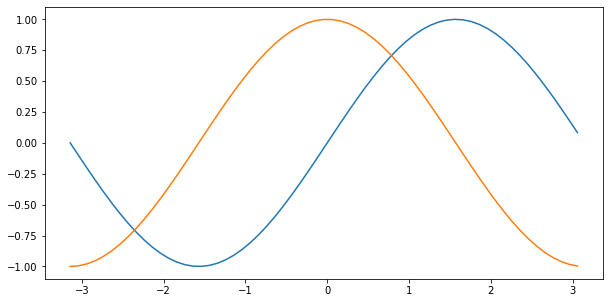

In [74]:
rcParams['figure.figsize'] = 10, 5
x = np.arange(-math.pi, math.pi, 0.1)
y = np.sin(x)
z = np.cos(x)
plt.plot(x, y, x, z)
plt.show()

суть DTW заключается в том, что "бугорок" у оранжевого графика DTW трансформирует так, чтобы между точками "бугорка" для синего графика и "бугорка" оранжевого графика были минимальные расстояния. Также трансформация будет и по иным точкам